In [23]:
from matplotlib import rc
from matplotlib import pyplot as plt
from json import load
from seaborn import regplot
from scipy import stats
from pandas import DataFrame

In [ ]:
# Font size
font = {'size': 20}
rc('font', **font)

# Data
folder:str = "temp/json/"
prefixes:list[str] = ["human_chr1","human_chr21", "yeast_chr1"]
suffixes:list[str] = ["_edition_results.json", "_vcf_results.json", "_trf_results.json", "_nodes_results.json", "_kmer_results.json", "_sd_results.json"]
references:list[str] = ["CHM13#CHR1", "CHM13#CHR21", "CASBJU01"]
indx:int = 2
datas:list[dict] = [load(open(filename)) for filename in [folder + prefixes[indx] + suffix for suffix in suffixes]]
refsize = datas[1]['reference_size']
satellites_annotations:str = "censat_annotation.csv"


# Parameters
kb:int = 1000
sampling:int = len(datas[1]['shared_variants'])
colors:dict[str,str] = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00'
}
# Normalisation
def norm(data:list, ref_size: int) -> list[float]:
    ratio = ref_size / len(data)
    return [(d/ratio)*kb for d in data]

def maxnorm(data:list) -> list[float]:
    return [(d/max(data))*kb for d in data]

print(refsize)

248387328


In [25]:
window_size:int = refsize / sampling
window_size

1241936.64

In [26]:
# Figures parameters:
with_legend:bool = False
with_axes_names:bool = True
with_bottom_axes:bool = False

In [27]:
satellites:list[list[tuple[int,int]]] = [list() for _ in range(len(prefixes))]

with open(satellites_annotations,'r',encoding='utf-8') as reader:
    next(reader)
    for line in reader:
        satellites[prefixes.index(line.split(',')[0]+'_'+line.split(',')[1])].append((int(line.split(',')[2]),int(line.split(',')[3])))


In [28]:
if indx == 2:
    title = "A) Yeast chr.1 (CASBJU01)"
    correct_positions:list = [y for y in range(0,refsize) if y % 5e4 == 0]
    xticks_positions:list = [(x/refsize)*sampling for x in correct_positions]
    mb_labels = [f'{int(x/1e3)}kb' if x !=0 else 0 for x in correct_positions]
if indx == 1:
    title = "B) Human chr.21 (CHM13)"
    correct_positions:list = [y for y in range(0,refsize) if y % 1e7 == 0]
    xticks_positions:list = [(x/refsize)*sampling for x in correct_positions]
    mb_labels = [f'{int(x/1e6)}Mb' if x !=0 else 0 for x in correct_positions]
if indx == 0:
    title = "C) Human chr.1 (CHM13)"
    correct_positions:list = [y for y in range(0,refsize) if y % 5e7 == 0]
    xticks_positions:list = [(x/refsize)*sampling for x in correct_positions]
    mb_labels = [f'{int(x/1e6)}Mb' if x !=0 else 0 for x in correct_positions]
plt.rcParams.update({'font.size': 20})
    

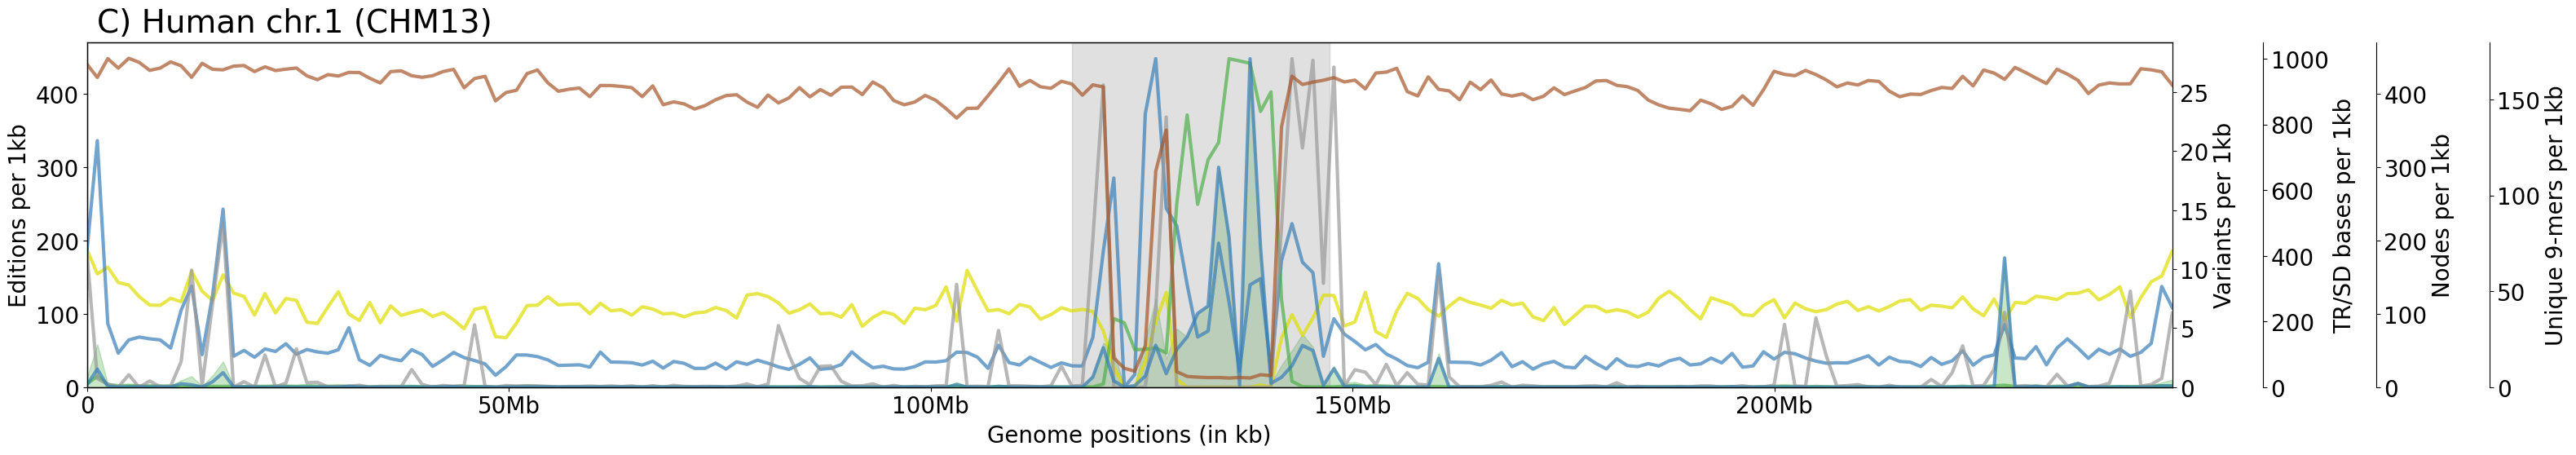

<Figure size 640x480 with 0 Axes>

In [29]:
private_variants = norm([x+y for x,y in zip(datas[1]['private_variants_A'],datas[1]['private_variants_B'])], refsize)
shared_variants = norm([x/2 for x in datas[1]['shared_variants']], refsize)
editions = norm(datas[0]['editions'][references[indx]], refsize)
tandem_repeats = norm(datas[2]['tandem_repeats'], refsize)
trf_normalised:list = maxnorm(tandem_repeats)
nodes_A = norm(datas[3]['nodes_A'], refsize)
nodes_B = norm(datas[3]['nodes_B'], refsize)
delta_nodes = [abs(x-y) for x,y in zip(nodes_A,nodes_B)]
kmers_normalised = norm(datas[4]['unique_kmers'], refsize)
segmental_duplications = maxnorm(norm(datas[5]['segmental_duplications'], refsize))


fig, ax = plt.subplots(figsize=(32,6))

secax = ax.secondary_xaxis('bottom')
secax.set_xticks(xticks_positions,mb_labels)
ax.set_xticklabels([])
ax.tick_params(axis='x', which='both', bottom=False, top=False, pad=25)

ax.fill_between(list(range(sampling)),editions, color=colors['green'], label='edits', alpha=.3)
ax.set_ylabel(f'Editions per 1kb')
ax.set_xlabel(f'Genome positions (in kb)')
if with_legend:
    ax.legend(loc=(.20,.995),frameon=False)
ax.set_xlim(left=0,right=sampling-1)
ax.set_ylim(bottom=0)

axb = ax.twinx()
axb.set_ylabel(f'Variants per 1kb')
axb.set_xticks([0]+[__-1 for __ in range(1,sampling+2) if not __%40])
for start,end in satellites[indx]:
    axb.axvspan((start/refsize)*sampling, (end/refsize)*sampling, alpha=0.3, color=colors['gray'])
axb.plot(shared_variants,color=colors['yellow'], label='shared',linewidth=3, alpha=.7) 
axb.plot(private_variants,color=colors['blue'], label='private',linewidth=3, alpha=.7) 
if with_legend:
    axb.legend(loc=(.4,.995),frameon=False,ncol=2)
axb.set_xlim(left=0,right=sampling-1)
axb.set_ylim(bottom=0)

axc = ax.twinx()
axc.spines['right'].set_position(('outward', 80))
axc.spines['right'].set_color('black')
axc.yaxis.label.set_color('black')
axc.tick_params(axis='y', colors='black')
axc.plot(trf_normalised,color=colors['green'], label='TR',linewidth=3, alpha=.7)
axc.plot(segmental_duplications,color=colors['gray'], label='SD',linewidth=3, alpha=.7)
if with_legend:
    axc.legend(loc=(.65,.995),frameon=False,ncol=2)
axc.set_ylabel(f'TR/SD bases per 1kb')
axc.set_ylim(bottom=0)

axd = ax.twinx()
axd.spines['right'].set_position(('outward', 180))
axd.spines['right'].set_color('black')
axd.yaxis.label.set_color('black')
axd.tick_params(axis='y', colors='black')
axd.plot(delta_nodes,color=colors['blue'], label='$\Delta_{nodes}$',linewidth=3, alpha=.7)
if with_legend:
    axd.legend(loc=(.30,.995),frameon=False)
axd.set_ylabel(f'Nodes per 1kb')
axd.set_ylim(bottom=0)

axe = ax.twinx()
axe.spines['right'].set_position(('outward', 280))
axe.spines['right'].set_color('black')
axe.yaxis.label.set_color('black')
axe.tick_params(axis='y', colors='black')
axe.plot(kmers_normalised,color=colors['brown'], label='9-mers',linewidth=3, alpha=.7)
if with_legend:
    axe.legend(loc=(.85,.995),frameon=False)
axe.set_ylabel(f'Unique 9-mers per 1kb')
axe.set_ylim(bottom=0)

ax.text(.005,1.03, title,horizontalalignment='left',transform=ax.transAxes,fontdict={'size':28})

plt.tight_layout()
plt.show()
plt.clf()

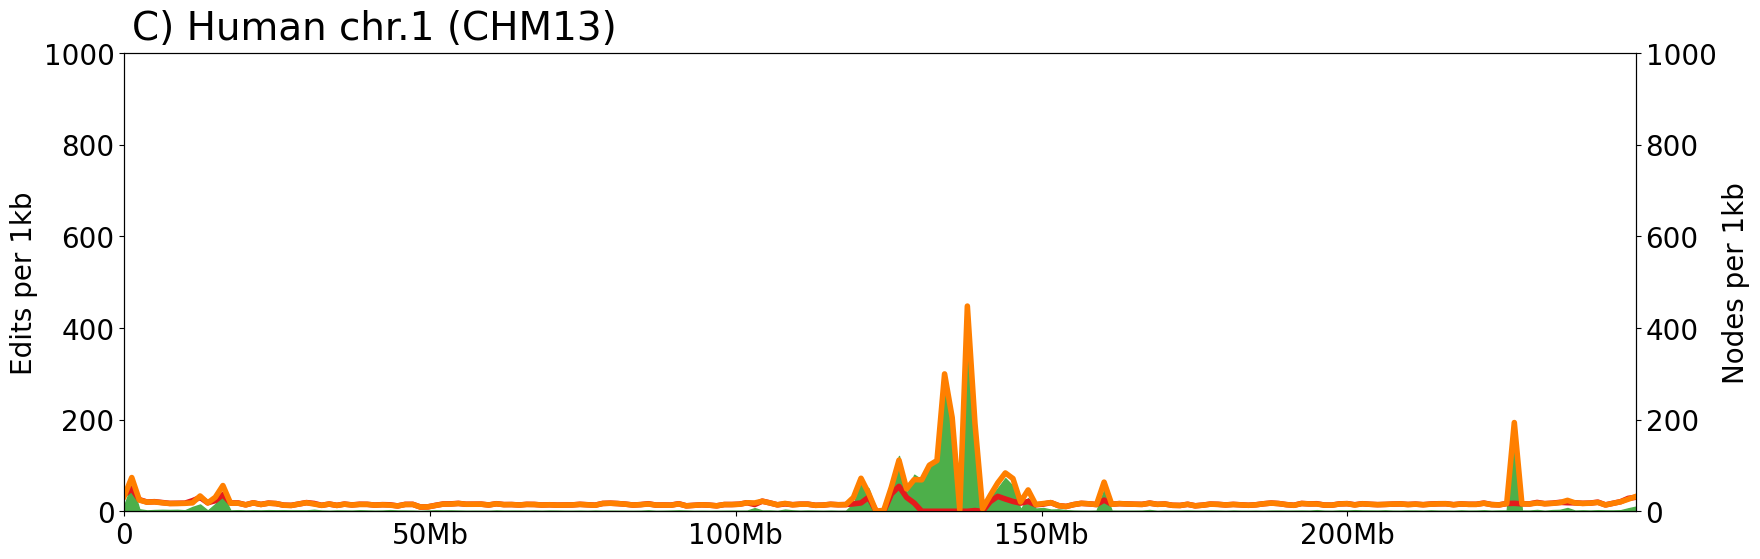

<Figure size 640x480 with 0 Axes>

In [30]:
# FIG2 - editions + nodes + delta nodes

fig, ax = plt.subplots(figsize=(18,6))

secax = ax.secondary_xaxis('bottom')
secax.set_xticks(xticks_positions,mb_labels)
ax.set_xticklabels([])
ax.tick_params(axis='x', which='both', bottom=False, top=False, pad=25)

ax.fill_between(list(range(sampling)),editions, color=colors['green'], label='edits', alpha=1)
if with_axes_names:
    ax.set_ylabel(f'Edits per 1kb')
else:
    ax.set_ylabel(f' ')
if with_bottom_axes:
    ax.set_xlabel(f'Genome positions (in kb)')
if with_legend:
    ax.legend(loc=(.4,.995),frameon=False)
ax.set_xlim(left=0,right=sampling-1)
ax.set_ylim(bottom=0,top=1000)

axb = ax.twinx()
if with_axes_names:
    axb.set_ylabel(f'Nodes per 1kb')
else:
    axb.set_ylabel(f' ')
axb.set_xticks([0]+[__-1 for __ in range(1,sampling+2) if not __%40])
axb.plot(nodes_A,color=colors['red'], label='$MC_{nodes}$',linewidth=4, alpha=1)
axb.plot(nodes_B,color=colors['orange'], label='$PGGB_{nodes}$',linewidth=4, alpha=1)
#axb.plot(delta_nodes,color=colors['yellow'], label='$\Delta_{nodes}$',linewidth=2, alpha=1, linestyle='-.')
if with_legend:
    axb.legend(loc=(.55,.995),frameon=False,ncol=3)
axb.set_xlim(left=0,right=sampling-1)
axb.set_ylim(bottom=0,top=1000)

ax.text(.005,1.03, title,horizontalalignment='left',transform=ax.transAxes,fontdict={'size':28})

plt.tight_layout()
plt.savefig("F2A.eps")
plt.show()
plt.clf()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


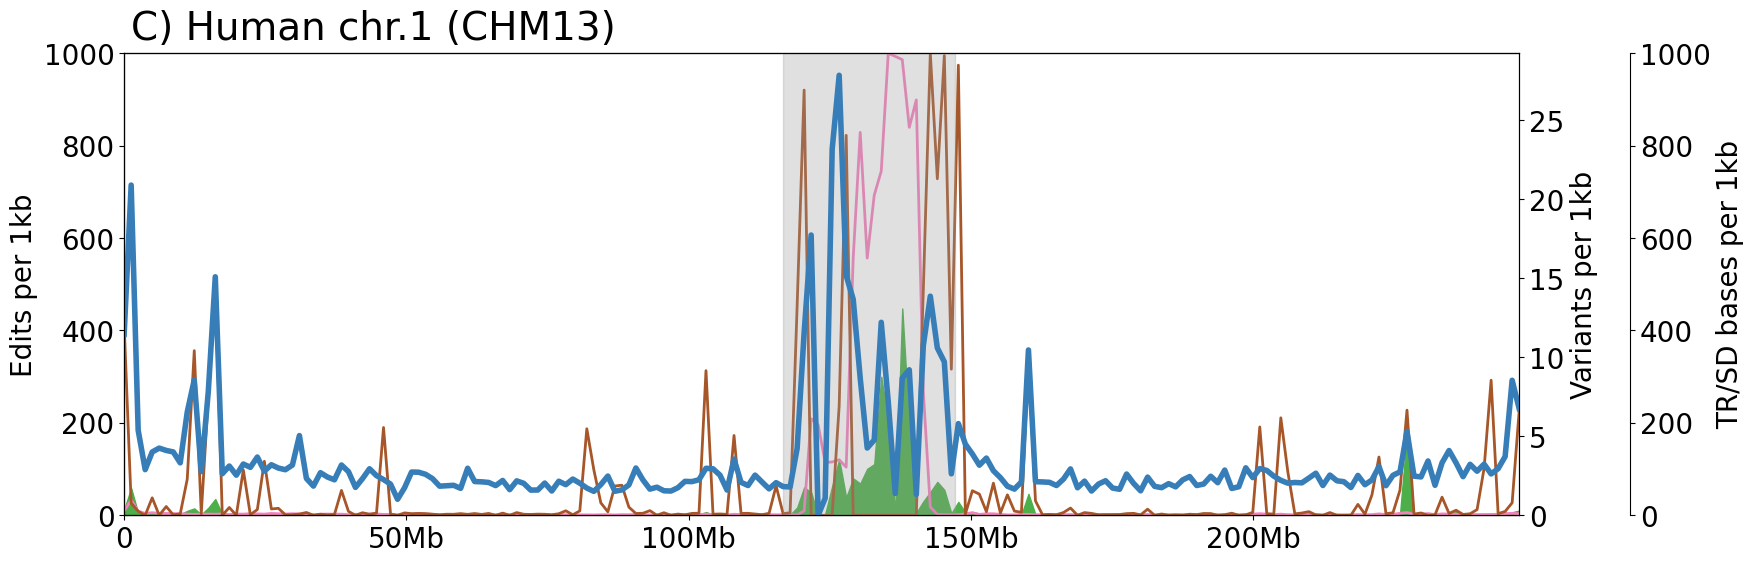

1000.0


<Figure size 640x480 with 0 Axes>

In [31]:
# FIG2 - editions + nodes + delta nodes

fig, ax = plt.subplots(figsize=(18,6))

secax = ax.secondary_xaxis('bottom')
secax.set_xticks(xticks_positions,mb_labels)
ax.set_xticklabels([])
ax.tick_params(axis='x', which='both', bottom=False, top=False, pad=25)

ax.fill_between(list(range(sampling)),editions, color=colors['green'], label='edits', alpha=1)
if with_axes_names:
    ax.set_ylabel(f'Edits per 1kb')
if with_bottom_axes:
    ax.set_xlabel(f'Genome positions (in kb)')
if with_legend:
    ax.legend(loc=(.38,.995),frameon=False)
ax.set_xlim(left=0,right=sampling-1)
ax.set_ylim(bottom=0,top=1000)


axc = ax.twinx()
axc.spines['right'].set_position(('outward', 80))
axc.spines['right'].set_color('black')
axc.yaxis.label.set_color('black')
axc.tick_params(axis='y', colors='black')
axc.plot(trf_normalised,color=colors['pink'], label='TR',linewidth=2, alpha=1)
axc.plot(segmental_duplications,color=colors['brown'], label='SD',linewidth=2, alpha=1)
if with_legend:
    axc.legend(loc=(.83,.995),frameon=False,ncol=2)
if with_axes_names:
    axc.set_ylabel(f'TR/SD bases per 1kb')
axc.set_ylim(bottom=0,top=1000)

axb = ax.twinx()
if with_axes_names:
    axb.set_ylabel(f'Variants per 1kb')

axb.set_xticks([0]+[__-1 for __ in range(1,sampling+2) if not __%40])
for x,(start,end) in enumerate(satellites[indx]):
    if x==0:
        axb.axvspan((start/refsize)*sampling, (end/refsize)*sampling, alpha=.3, color=colors['gray'], label='Cen/Tel')
    else:
        axb.axvspan((start/refsize)*sampling, (end/refsize)*sampling, alpha=0.3, color=colors['gray'])
axb.plot(private_variants,color=colors['blue'], label='GPV',linewidth=4, alpha=1)
if with_legend:
    axb.legend(loc=(.53,.995),frameon=False,ncol=3)
axb.set_xlim(left=0,right=sampling-1)
axb.set_ylim(bottom=0)

ax.text(.005,1.03, title,horizontalalignment='left',transform=ax.transAxes,fontdict={'size':28})

#plt.tight_layout()
plt.savefig("F3A.eps")
plt.show()
plt.clf()
print(max(segmental_duplications))


In [32]:
print(f"Shared variants = {int(sum([x/2 for x in datas[1]['shared_variants']]))}")
print(f"Private variants = {sum([x+y for x,y in zip(datas[1]['private_variants_A'],datas[1]['private_variants_B'])])}")

Shared variants = 1588095
Private variants = 904311


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


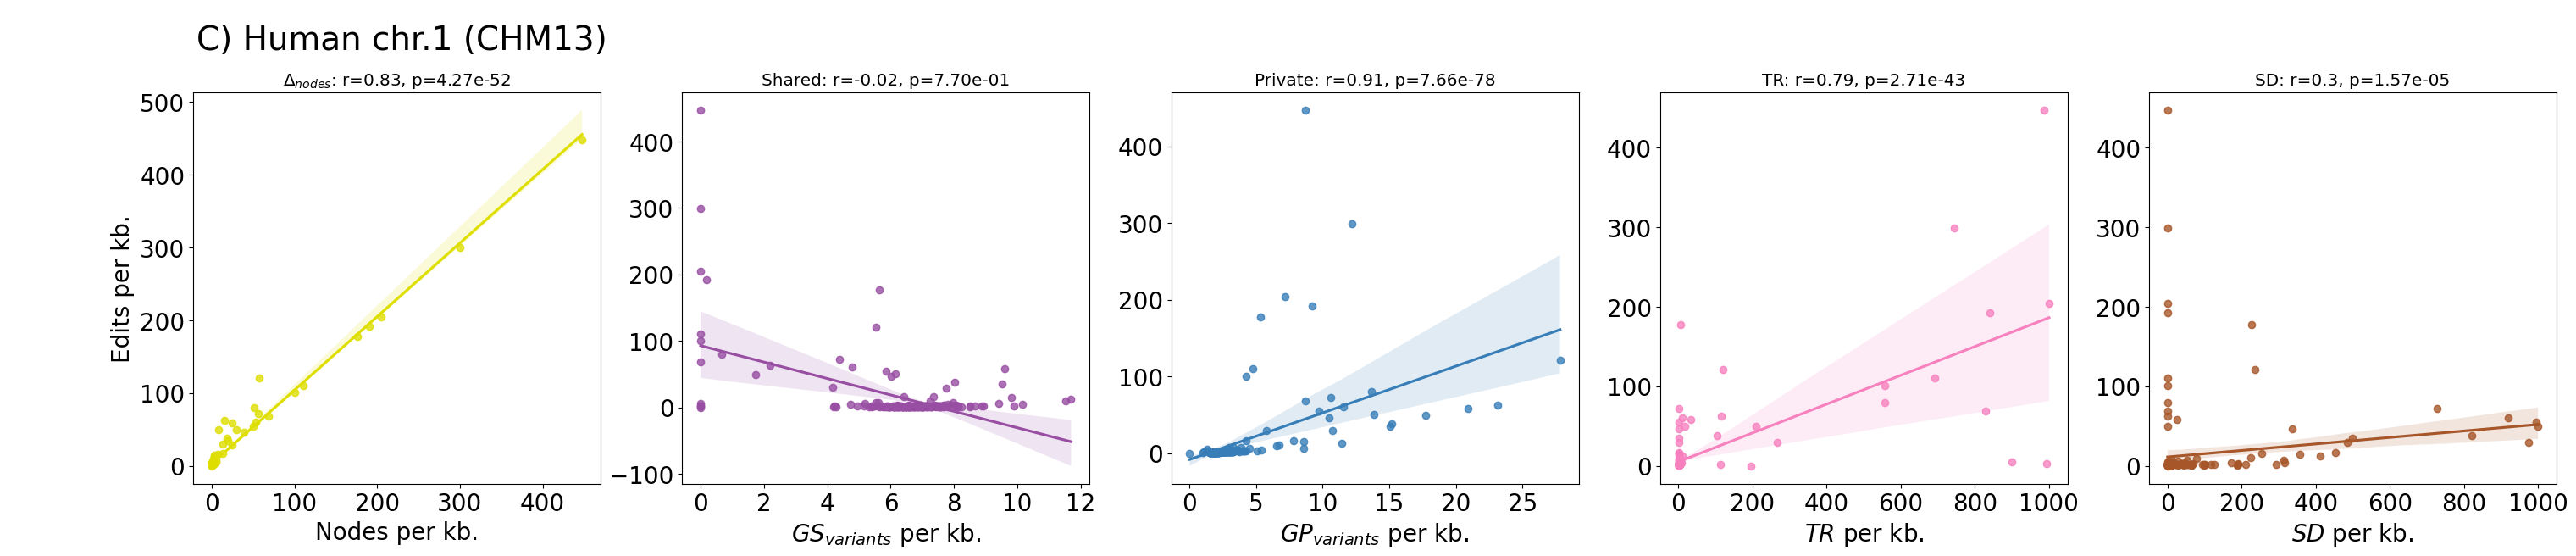

In [33]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(36,6))

plt.rcParams.update({'font.size': 12})

df_ve:DataFrame = DataFrame(
    data={
        'edition_count':editions,
        'shared_variants':shared_variants,
        'private_variants':private_variants,
        'tandem_repeats':trf_normalised,
        'delta_nodes':delta_nodes,
        'kmers':kmers_normalised,
        'segmental_duplications':segmental_duplications
    }
)

ax1.text(.005,1.15, title,horizontalalignment='left',transform=ax.transAxes,fontdict={'size':28})

ax1.set_title("$\Delta_{nodes}$:" + f" r={round(stats.spearmanr(df_ve['delta_nodes'], df_ve['edition_count'])[0],2)}, p={stats.spearmanr(df_ve['delta_nodes'], df_ve['edition_count'])[1]:.2e}")
regplot(x='delta_nodes', y='edition_count', data=df_ve, ax=ax1, color=colors['yellow'])
ax1.set_ylabel('Edits per kb.')
ax1.set_xlabel('Nodes per kb.')

ax2.set_title(f"Shared: r={round(stats.spearmanr(df_ve['shared_variants'], df_ve['edition_count'])[0],2)}, p={stats.spearmanr(df_ve['shared_variants'], df_ve['edition_count'])[1]:.2e}")
regplot(x='shared_variants', y='edition_count', data=df_ve, ax=ax2, color=colors['purple'])
ax2.set_ylabel('')
ax2.set_xlabel('$GS_{variants}$ per kb.')

ax3.set_title(f"Private: r={round(stats.spearmanr(df_ve['private_variants'], df_ve['edition_count'])[0],2)}, p={stats.spearmanr(df_ve['private_variants'], df_ve['edition_count'])[1]:.2e}")
regplot(x='private_variants', y='edition_count', data=df_ve, ax=ax3, color=colors['blue'])
ax3.set_ylabel('')
ax3.set_xlabel('$GP_{variants}$ per kb.')

ax4.set_title(f"TR: r={round(stats.spearmanr(df_ve['tandem_repeats'], df_ve['edition_count'])[0],2)}, p={stats.spearmanr(df_ve['tandem_repeats'], df_ve['edition_count'])[1]:.2e}")
regplot(x='tandem_repeats', y='edition_count', data=df_ve, ax=ax4, color=colors['pink'])
ax4.set_ylabel('')
ax4.set_xlabel('$TR$ per kb.')

#ax5.set_title(f"Kmers: r={round(stats.spearmanr(df_ve['kmers'], df_ve['edition_count'])[0],2)}, p={stats.spearmanr(df_ve['kmers'], df_ve['edition_count'])[1]:.2e}")
#regplot(x='kmers', y='edition_count', data=df_ve, ax=ax5, color=colors['brown'])
#ax5.set_ylabel('')
#ax5.set_xlabel('Unique 9-$mers$ per kb.')

ax5.set_title(f"SD: r={round(stats.spearmanr(df_ve['segmental_duplications'], df_ve['edition_count'])[0],2)}, p={stats.spearmanr(df_ve['segmental_duplications'], df_ve['edition_count'])[1]:.2e}")
regplot(x='segmental_duplications', y='edition_count', data=df_ve, ax=ax5, color=colors['brown'])
ax5.set_ylabel('')
ax5.set_xlabel('$SD$ per kb.')

plt.savefig("SF5A.eps")
plt.show()